# 2018-10-30 : LIP Spiking Network
## 1/ Initialisation
Pour faire des réseaux de neurones spiking en Python, le plus simple est d'utiliser une toolbox qui s'appelle PyNN : c'est un meta-simulateur qui regroupe les simulateurs les plus connus tout en ayant une interface de haut-niveau (relativement) simple. 

Le seul souci c'est qu'il est pas simple à installer et je crois qu'il est même carrément pas disponible si tu es sur Windows... à voir quand Laurent reviens, il a surement une astuce pour le faire marcher

On importe PyNN et un simulateur efficace, NEST :

In [1]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution, NumpyRNG

print('Les avertissements ne servent à rien on peut les ignorer')

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH
Les avertissements ne servent à rien on peut les ignorer


/home/hugo/.local/lib/python3.7/site-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DictError in SLIInterpreter::execute: Key '/Install' does not exist in dictionary.
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


## 2/ Paramètres des neurones

On peut définir les paramètres des neurones avec un dictionnaire Python. Celles là viennent d'un moyennage de cortex moteur de rat (McCormick et al, 95) complémentés avec des datas de l'EPFL (2015-ish?) :

In [2]:
sim.IF_cond_exp.default_parameters

{'v_rest': -65.0,
 'cm': 1.0,
 'tau_m': 20.0,
 'tau_refrac': 0.1,
 'tau_syn_E': 5.0,
 'tau_syn_I': 5.0,
 'e_rev_E': 0.0,
 'e_rev_I': -70.0,
 'v_thresh': -50.0,
 'v_reset': -65.0,
 'i_offset': 0.0}

In [3]:
neuron_parameters = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -65.5, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick
                    }

Chaque neurone / ensemble de neurones est défini comme une population du simulateur qu'on a instancié plus haut. Histoire de faire quelque chose de clair et didactique on va les créer un a un, mais c'est pas la manière la plus efficace (i.e. Laurent me taperait sur les doigts si il voyait ça).

Concernant le modèle lui même, le simulateur en a pas mal mais le plus courant c'est le conductance-based avec des constantes de temps exponentielles (IF_cond_exp)


Tu peux aussi rajouter de la distance et de la topologie dans le réseau si jamais tu pense que c'est un facteur dans le LIP. Et changer les paramètres d'excitabilité de chaque neurone indépendament.

In [4]:
#on lance le simulateur pour qu'il intègre les modèles a venir
sim.setup()

#nom du neurone = sim.Population(nbr neurone, type de neurone(paramètres), valeurs initiales, label)
M_NM = sim.Population(1, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Match/NonMatch")

I = sim.Population(1, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Constant Inhibitor")

Test_A = sim.Population(1, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Test A")
Test_B = sim.Population(1, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Test B")

Sample_A = sim.Population(1, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Sample A")
Sample_B = sim.Population(1, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Sample B")

Inter_A = sim.Population(1, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Inter A")
Inter_B = sim.Population(1, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Inter B")

## 3/ Connectivité

Comme tu l'as remarqué c'est pas dans le neurone qu'on défini le type de neurotransmetteur, ça se fait directement dans la connectivité. Comme pour les neurones, on va la faire synapse par synapse, ça sera plus clair et modulable. L'objet ici c'est sim.Projection()

Pour l'instant je les mets en synapse statique mais il y a des tas de modèles pour la plasticité qu'on peut intégrer

In [5]:
#schéma de connexion des synapses une a une, mais demande que les deux pops soient de taille identiques
one_connector = sim.OneToOneConnector() 

#plasticité de la synapse, ici j'en mets pas mais si c'est de l'apprentissage ça serait intéressant de 
#tester la STDP
#poids en nA (ou nS ?) et delai synaptique en ms
static_syn = sim.StaticSynapse(weight = .5, delay = 2)

#################
# Les inhibiteurs
#################
#sim.Projection(presyn_pop, postsyn_pop, schema de connexion, type de synapse, type de recepteurs, label)
I_to_MNM = sim.Projection(I, M_NM,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='inhibitory',
                        label="I to MNM connection")
Ia_to_I = sim.Projection(Inter_A, I,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='inhibitory',
                        label="Ia to I connection")
Ib_to_I = sim.Projection(Inter_B, I,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='inhibitory',
                        label="Ib to I connection")

#################
# Les tests
#################
TA_to_MNM = sim.Projection(Test_A, M_NM,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="TA to MNM connection")
TA_to_Ib = sim.Projection(Test_A, Inter_B,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="TA to Ib connection")
TB_to_MNM = sim.Projection(Test_B, M_NM,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="TB to MNM connection")
TB_to_Ia = sim.Projection(Test_B, Inter_A,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="TB to Ia connection")

#################
# Les priors
#################
SA_to_MNM = sim.Projection(Sample_A, M_NM,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="SA to MNM connection")
SA_to_Ia = sim.Projection(Sample_A, Inter_A,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="SA to Ia connection")
SB_to_MNM = sim.Projection(Sample_B, M_NM,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="SA to Ia connection")
SB_to_Ib = sim.Projection(Sample_B, Inter_B,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="SA to Ia connection")

On défini des injections de courants sinon il se passera pas grand chose.

Ici j'injecte un pulse de courant continu dans le sample A pour faire augmenter le firing rate, puis une injection delayée d'une dizaine de ms dans test A pour faire un match 

In [6]:
amp = .3
pulse = sim.DCSource(amplitude = amp, start = 300., stop = 350.)
pulse.inject_into(Sample_A)

pulse2 = sim.DCSource(amplitude = amp, start = 310., stop = 350.)
pulse2.inject_into(Test_A)

pulse3 = sim.DCSource(amplitude = amp/2, start = 100., stop = 800.)
pulse3.inject_into(I)

On enregistre les variations des neurones pendant la simulation

In [7]:
M_NM.record(['spikes', 'v'])
I.record(['spikes', 'v'])
Test_A.record(['spikes', 'v'])
Test_B.record(['spikes', 'v'])
Sample_A.record(['spikes', 'v'])
Sample_B.record(['spikes', 'v'])
Inter_A.record(['spikes', 'v'])
Inter_B.record(['spikes', 'v'])

sim.run(1000)
sim.end()

Maintenant on plotte

In [8]:
import matplotlib.pyplot as plt

M_NM_data = M_NM.get_data()
M_NM_voltage = M_NM_data.filter(name = 'v')[0]

Test_A = Test_A.get_data()
Test_A_voltage = Test_A.filter(name = 'v')[0]

Sample_A = Sample_A.get_data()
Sample_A_voltage = Sample_A.filter(name = 'v')[0]

I = I.get_data()
I_voltage = I.filter(name = 'v')[0]

Inter_A = Inter_A.get_data()
Inter_A_voltage = Inter_A.filter(name = 'v')[0]

Text(0.5,0.98,'Match case (TestA+SampleA)')

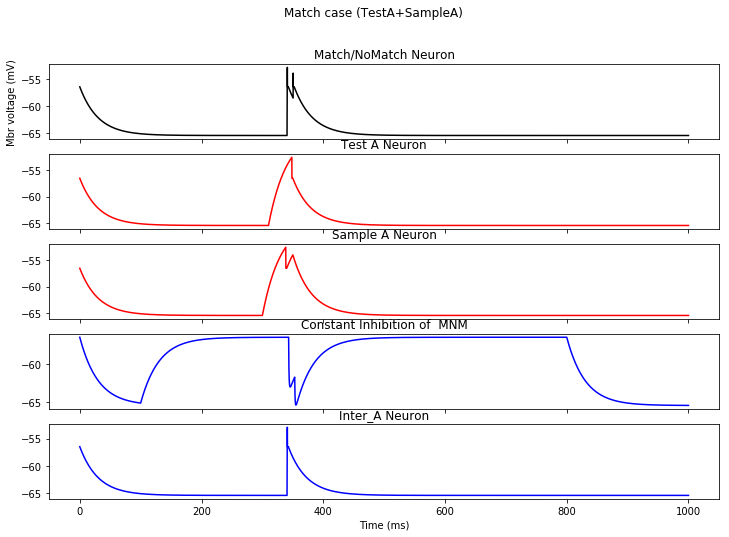

In [9]:
fig, axs = plt.subplots(5,1, figsize = (12,8))

axs[0].plot(M_NM_voltage, color = 'black')
axs[0].set_title('Match/NoMatch Neuron')
axs[0].set_xticklabels([])
axs[0].set_ylabel('Mbr voltage (mV)')


axs[1].plot(Test_A_voltage, color = 'r')
axs[1].set_title('Test A Neuron')
axs[1].set_xticklabels([])

axs[2].plot(Sample_A_voltage, color = 'r')
axs[2].set_title('Sample A Neuron')
axs[2].set_xticklabels([])

axs[3].plot(I_voltage, color = 'b')
axs[3].set_title('Constant Inhibition of  MNM')
axs[3].set_xticklabels([])

axs[4].plot(Inter_A_voltage, color = 'b')
axs[4].set_title('Inter_A Neuron')
axs[4].set_xticklabels([0,0,200,400,600,800,1000])
axs[4].set_xlabel('Time (ms)')

plt.suptitle('Match case (TestA+SampleA)')

Maintenant en no match

In [10]:
#on lance le simulateur pour qu'il intègre les modèles a venir
sim.setup()

#nom du neurone = sim.Population(nbr neurone, type de neurone(paramètres), valeurs initiales, label)
M_NM = sim.Population(1, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Match/NonMatch")

I = sim.Population(1, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Constant Inhibitor")

Test_A = sim.Population(1, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Test A")
Test_B = sim.Population(1, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Test B")

Sample_A = sim.Population(1, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Sample A")
Sample_B = sim.Population(1, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Sample B")

Inter_A = sim.Population(1, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Inter A")
Inter_B = sim.Population(1, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Inter B")

#schéma de connexion des synapses une a une, mais demande que les deux pops soient de taille identiques
one_connector = sim.OneToOneConnector() 

#plasticité de la synapse, ici j'en mets pas mais si c'est de l'apprentissage ça serait intéressant de 
#tester la STDP
#poids en nA (ou nS ?) et delai synaptique en ms
static_syn = sim.StaticSynapse(weight = .5, delay = 2)

#################
# Les inhibiteurs
#################
#sim.Projection(presyn_pop, postsyn_pop, schema de connexion, type de synapse, type de recepteurs, label)
I_to_MNM = sim.Projection(I, M_NM,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='inhibitory',
                        label="I to MNM connection")
Ia_to_I = sim.Projection(Inter_A, I,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='inhibitory',
                        label="Ia to I connection")
Ib_to_I = sim.Projection(Inter_B, I,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='inhibitory',
                        label="Ib to I connection")

#################
# Les tests
#################
TA_to_MNM = sim.Projection(Test_A, M_NM,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="TA to MNM connection")
TA_to_Ib = sim.Projection(Test_A, Inter_B,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="TA to Ib connection")
TB_to_MNM = sim.Projection(Test_B, M_NM,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="TB to MNM connection")
TB_to_Ia = sim.Projection(Test_B, Inter_A,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="TB to Ia connection")

#################
# Les priors
#################
SA_to_MNM = sim.Projection(Sample_A, M_NM,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="SA to MNM connection")
SA_to_Ia = sim.Projection(Sample_A, Inter_A,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="SA to Ia connection")
SB_to_MNM = sim.Projection(Sample_B, M_NM,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="SA to Ia connection")
SB_to_Ib = sim.Projection(Sample_B, Inter_B,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="SA to Ia connection")

amp = .3

pulse = sim.DCSource(amplitude = amp, start = 300., stop = 350.)
pulse.inject_into(Sample_A)

pulse2 = sim.DCSource(amplitude = amp, start = 310., stop = 350.)
pulse2.inject_into(Test_B)

pulse3 = sim.DCSource(amplitude = amp/2, start = 100., stop = 800.)
pulse3.inject_into(I)

M_NM.record(['spikes', 'v'])
I.record(['spikes', 'v'])
Test_A.record(['spikes', 'v'])
Test_B.record(['spikes', 'v'])
Sample_A.record(['spikes', 'v'])
Sample_B.record(['spikes', 'v'])
Inter_A.record(['spikes', 'v'])
Inter_B.record(['spikes', 'v'])

sim.run(1000)
sim.end()

In [11]:
import matplotlib.pyplot as plt

M_NM_data = M_NM.get_data()
M_NM_voltage = M_NM_data.filter(name = 'v')[0]

Test_B = Test_B.get_data()
Test_B_voltage = Test_B.filter(name = 'v')[0]

Sample_A = Sample_A.get_data()
Sample_A_voltage = Sample_A.filter(name = 'v')[0]

I = I.get_data()
I_voltage = I.filter(name = 'v')[0]

Inter_A = Inter_A.get_data()
Inter_A_voltage = Inter_A.filter(name = 'v')[0]

Text(0.5,0.98,'No Match case (TestB+SampleA)')

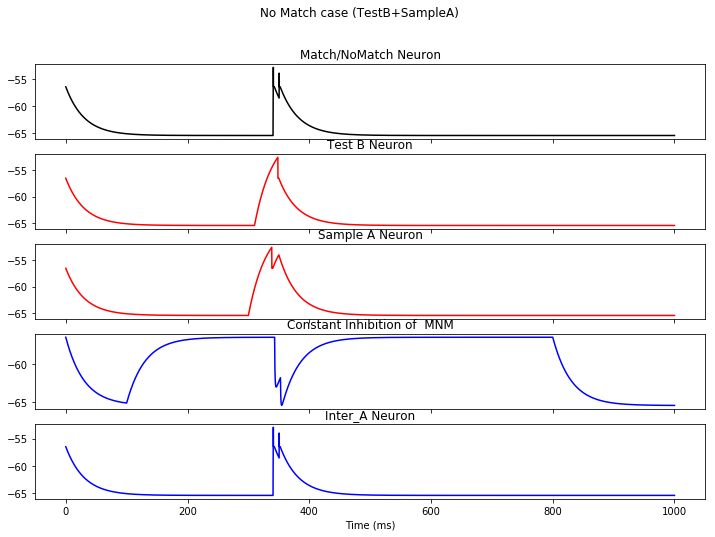

In [12]:
fig, axs = plt.subplots(5,1, figsize = (12,8))

axs[0].plot(M_NM_voltage, color = 'black')
axs[0].set_title('Match/NoMatch Neuron')
axs[0].set_xticklabels([])

axs[1].plot(Test_A_voltage, color = 'r')
axs[1].set_title('Test B Neuron')
axs[1].set_xticklabels([])

axs[2].plot(Sample_A_voltage, color = 'r')
axs[2].set_title('Sample A Neuron')
axs[2].set_xticklabels([])

axs[3].plot(I_voltage, color = 'b')
axs[3].set_title('Constant Inhibition of  MNM')
axs[3].set_xticklabels([])

axs[4].plot(Inter_A_voltage, color = 'b')
axs[4].set_title('Inter_A Neuron')
axs[4].set_xticklabels([0,0,200,400,600,800,1000])
axs[4].set_xlabel('Time (ms)')

plt.suptitle('Match case (TestA+SampleA)')

plt.suptitle('No Match case (TestB+SampleA)')